In [ ]:
import mne
import pywt
# import ewtpy
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from mne.io import concatenate_raws
from sklearn.decomposition import FastICA
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout, LeakyReLU, Conv1D, Conv2D, BatchNormalization, Activation, AveragePooling2D, Reshape, MaxPooling1D, MaxPooling2D
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
all_paths = glob(os.path.join('/content/drive/MyDrive/data', '**', '*.edf'), recursive=True)

In [ ]:
print(len(all_paths))

1526


## Task 3 >> (open and close both fists or both feet) ---> subject_id [5,9,13]



In [ ]:
import random # Shuffle the list in-place
random.seed(1)

task3_05_paths = [path for path in all_paths if '05' in path.split('/')[-1][5:7]]
random.shuffle(task3_05_paths)
task3_05_paths = task3_05_paths[:105]
######################################################
task3_09_paths = [path for path in all_paths if '09' in path.split('/')[-1][5:7]]
random.shuffle(task3_09_paths)
task3_09_paths = task3_09_paths[:105]
######################################################
task3_13_paths = [path for path in all_paths if '13' in path.split('/')[-1][5:7]]
random.shuffle(task3_13_paths)
task3_13_paths = task3_13_paths[:105]
#####################################################
task3_paths = task3_05_paths + task3_09_paths + task3_13_paths
len(task3_paths)

315

In [ ]:
%%capture
# Load each of the files
parts_3 = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto',verbose='WARNING') for path in task3_paths]

In [ ]:
parts_3 = [part.resample(sfreq=128) for part in parts_3]

Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.


In [ ]:
# Concatenate them
raw_3 = concatenate_raws(parts_3, preload=True)
# Find the events in this dataset
events, _ = mne.events_from_annotations(raw_3)

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw_3.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [ ]:
raw_3.get_data().shape

(64, 4966144)

In [ ]:
raw_3.get_data().shape

(64, 4966144)

In [ ]:
epochs_3 = mne.Epochs(raw_3, events, dict(left=2, right=3),tmin=-0.5, tmax=0.5, baseline= None, proj=False, picks=eeg_channel_inds, preload=True)

Not setting metadata
4729 matching events found
No baseline correction applied
Using data from preloaded Raw for 4729 events and 129 original time points ...
0 bad epochs dropped


In [ ]:
epochs_3.equalize_event_counts(dict(left=2, right=3))

Dropped 27 epochs: 162, 489, 514, 521, 692, 917, 962, 981, 994, 1007, 1082, 1733, 1762, 1835, 2062, 2203, 2304, 2323, 2336, 3581, 3598, 3613, 3838, 3853, 3868, 3883, 4548


(<Epochs |  4702 events (all good), -0.5 – 0.5 s, baseline off, ~296.2 MB, data loaded,
  'left': 2351
  'right': 2351>,
 array([ 162,  489,  514,  521,  692,  917,  962,  981,  994, 1007, 1082,
        1733, 1762, 1835, 2062, 2203, 2304, 2323, 2336, 3581, 3598, 3613,
        3838, 3853, 3868, 3883, 4548]))

In [ ]:
features = (epochs_3.get_data()* 1e6).astype(np.float32)
labels = (epochs_3.events[:,-1] - 2).astype(np.int64)

In [ ]:
from sklearn.preprocessing import normalize

for i in range(features.shape[0]):

    features[i] = normalize(features[i], axis=0, norm = 'max')
features = (features+1)/2

In [ ]:
# np.min(X_scaled), np.max(X_scaled),
np.min(features), np.max(features)

(0.0, 1.0)

In [ ]:
print(features.mean())
print(features.std())

0.478412
0.21015193


In [ ]:
num_samples = features.shape[0]
num_channels = 30 # reduce the channels numbers from 64 to 25
signal_length = features.shape[2]

# Reshape EEG data for preprocessing
reshaped_data = features.reshape(num_samples, -1)

# Apply ICA
ica = FastICA(n_components=num_channels, max_iter=800,random_state=0)
ica_result = ica.fit_transform(reshaped_data)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [ ]:
# Apply SOBI
cov_matrix = np.cov(ica_result, rowvar=False)
eigenvalues, eigenvectors = eigh(cov_matrix)
sobi_result = np.dot(ica_result, eigenvectors)

In [ ]:
sobi_result.shape

(4702, 30)

In [ ]:
# Apply CWT (using PyWavelets library)
def apply_cwt(signal):
    wavelet = 'morl'  # Morlet wavelet
    scales = np.arange(1, 51)  # Adjust the scales based on your data
    cwt_result, _ = pywt.cwt(signal, scales, wavelet)
    return cwt_result

# Apply CWT to each sample in the SOBI result
cwt_results = np.array([apply_cwt(sample) for sample in sobi_result])

In [ ]:
cwt_results.shape

(4702, 50, 30)

In [ ]:
num_samples, sequence_length = ica_result.shape
# Reshape the data
reshaped_data = ica_result.reshape(num_samples, sequence_length, 1)
reshaped_data.shape

(4702, 30, 1)

In [ ]:
X_t = np.transpose(features, (0, 2, 1))
X_t.shape

(4702, 129, 64)

In [ ]:
# Define the parameters
def aug_train(X):
    num_samples, seq_len, features = X.shape

    # Randomly select a cut length between 1 and max_cut_length
    cut_length = seq_len//14
    new_seq_len = seq_len - 2* cut_length
    # Create an array to store the modified data
    modified_data = np.empty((num_samples, new_seq_len, features))
    # print(modified_data.shape)
    # Loop through each sample and apply the random cut
    for i in range(num_samples):
        cut_start = np.random.randint(0, cut_length )
        cut_end = cut_start + new_seq_len
        # print(cut_length, cut_start, cut_end)

        modified_data[i] = X[i, cut_start:cut_end, :]

    return modified_data

In [ ]:
def aug_test(X):
    num_samples, seq_len, features = X.shape

    # Randomly select a cut length between 1 and max_cut_length
    cut_length = seq_len//14
    new_seq_len = seq_len - 2* cut_length
    # Create an array to store the modified data
    modified_data = np.empty((num_samples, new_seq_len, features))
    for i in range(num_samples):
        cut_start = cut_length
        cut_end = cut_start + new_seq_len
        modified_data[i] = X[i, cut_start:cut_end, :]

    return modified_data

In [ ]:
# Define the parameters
num_samples, seq_len, features = X_t.shape
# Randomly select a cut length between 1 and max_cut_length
cut_length = 20
new_dim = seq_len - cut_length
# Create an array to store the modified data
modified_data = np.empty((num_samples, new_dim , features))
print(modified_data.shape)
# Loop through each sample and apply the random cut
for i in range(num_samples):
    cut_start = np.random.randint(0, cut_length + 1)
    cut_end = new_dim - (20 - cut_start)
    print(cut_length, cut_start, cut_end)

    modified_data[i] = X_t[i, cut_start:cut_end + cut_length, :]

In [ ]:
# Split the data randomly into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_t, labels, test_size=0.2, random_state=1233)

In [ ]:
x_train.shape, x_test.shape

((3761, 129, 64), (941, 129, 64))

In [ ]:
# Set a seed for TensorFlow
tf.random.set_seed(42)
# train_shape = (87, 64)

# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),  # LSTM layer with 128 units
    layers.Dropout(0.45),  # Dropout layer for regularization
    layers.LSTM(32, recurrent_dropout=0.25, return_sequences=True),  # LSTM layer with 32 units
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(16, activation=tf.nn.leaky_relu),  # Dense layer with ReLU activation
    layers.Dropout(0.35),  # Dropout layer for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification (adjust as needed)
])

opt = Adam(learning_rate=0.0002)


# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_lstm = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))
# Train the model
epochs_no= 50

Epoch 1/50
118/118 [==============================] - 42s 256ms/step - loss: 0.6897 - accuracy: 0.5435 - val_loss: 0.6715 - val_accuracy: 0.6472
Epoch 2/50
118/118 [==============================] - 26s 218ms/step - loss: 0.6570 - accuracy: 0.6270 - val_loss: 0.6359 - val_accuracy: 0.6823
Epoch 3/50
118/118 [==============================] - 25s 207ms/step - loss: 0.6386 - accuracy: 0.6426 - val_loss: 0.6157 - val_accuracy: 0.6536
Epoch 4/50
118/118 [==============================] - 28s 235ms/step - loss: 0.6214 - accuracy: 0.6559 - val_loss: 0.6036 - val_accuracy: 0.6833
Epoch 5/50
118/118 [==============================] - 26s 225ms/step - loss: 0.6128 - accuracy: 0.6700 - val_loss: 0.5943 - val_accuracy: 0.6971
Epoch 6/50
118/118 [==============================] - 26s 217ms/step - loss: 0.6037 - accuracy: 0.6764 - val_loss: 0.5837 - val_accuracy: 0.7024
Epoch 7/50
118/118 [==============================] - 27s 231ms/step - loss: 0.5916 - accuracy: 0.6894 - val_loss: 0.5813 - val_ac

30/30 [==============================] - 1s 37ms/step - loss: 0.6516 - accuracy: 0.7194
Test accuracy: 0.7194473743438721
Kappa: 0.43792931806869084
F1 Score: 0.7306122448979592
Precision: 0.7306122448979592
Recall: 0.7306122448979592


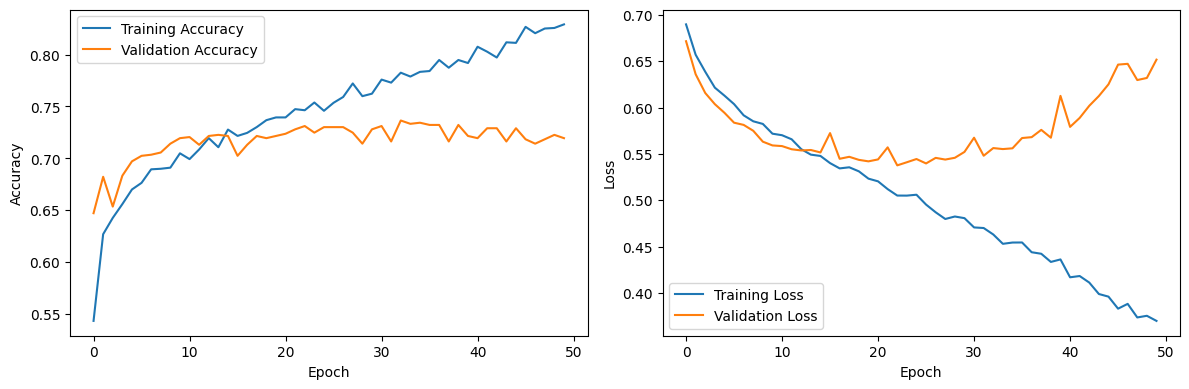

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

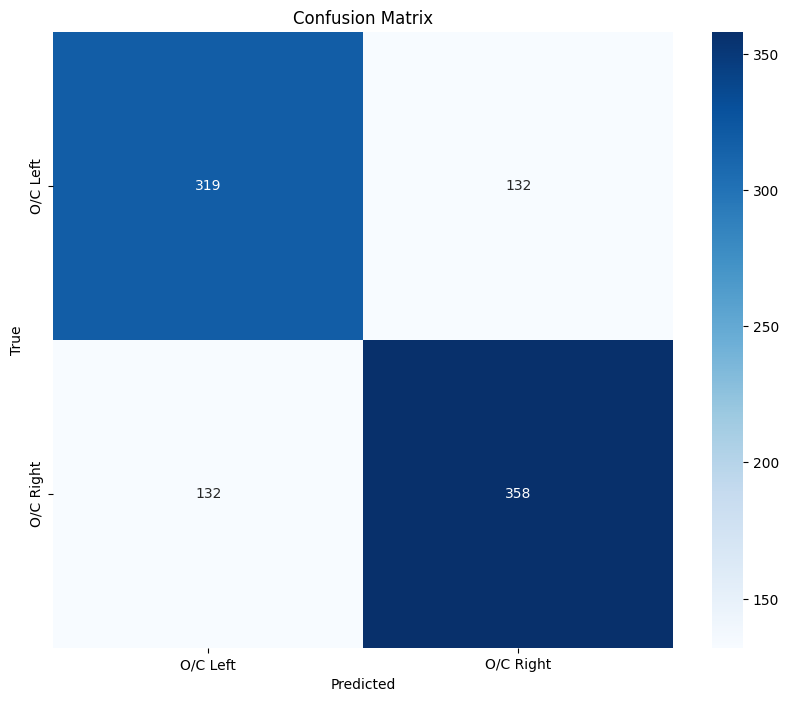

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.3, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.45))  # Dropout layer for regularization
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.35, return_sequences=True)))
model.add(Dropout(0.45))  # Dropout layer for regularization
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.3, return_sequences=True)))
model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))  # Binary classification


opt = Adam(learning_rate=0.0006)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_Bi = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/25
59/59 [==============================] - 73s 884ms/step - loss: 0.6645 - accuracy: 0.5900 - val_loss: 0.6410 - val_accuracy: 0.6451
Epoch 2/25
59/59 [==============================] - 48s 808ms/step - loss: 0.6254 - accuracy: 0.6506 - val_loss: 0.5991 - val_accuracy: 0.6833
Epoch 3/25
59/59 [==============================] - 48s 813ms/step - loss: 0.6092 - accuracy: 0.6645 - val_loss: 0.5860 - val_accuracy: 0.6812
Epoch 4/25
59/59 [==============================] - 47s 799ms/step - loss: 0.5968 - accuracy: 0.6748 - val_loss: 0.5802 - val_accuracy: 0.6897
Epoch 5/25
59/59 [==============================] - 47s 793ms/step - loss: 0.5813 - accuracy: 0.6940 - val_loss: 0.5765 - val_accuracy: 0.6876
Epoch 6/25
59/59 [==============================] - 47s 803ms/step - loss: 0.5665 - accuracy: 0.6985 - val_loss: 0.5749 - val_accuracy: 0.7078
Epoch 7/25
59/59 [==============================] - 48s 807ms/step - loss: 0.5602 - accuracy: 0.7051 - val_loss: 0.5685 - val_accuracy: 0.7109

30/30 [==============================] - 3s 91ms/step - loss: 0.5854 - accuracy: 0.7290
Test accuracy: 0.7290117144584656
Kappa: 0.46160404770185226
F1 Score: 0.711864406779661
Precision: 0.7974683544303798
Recall: 0.6428571428571429


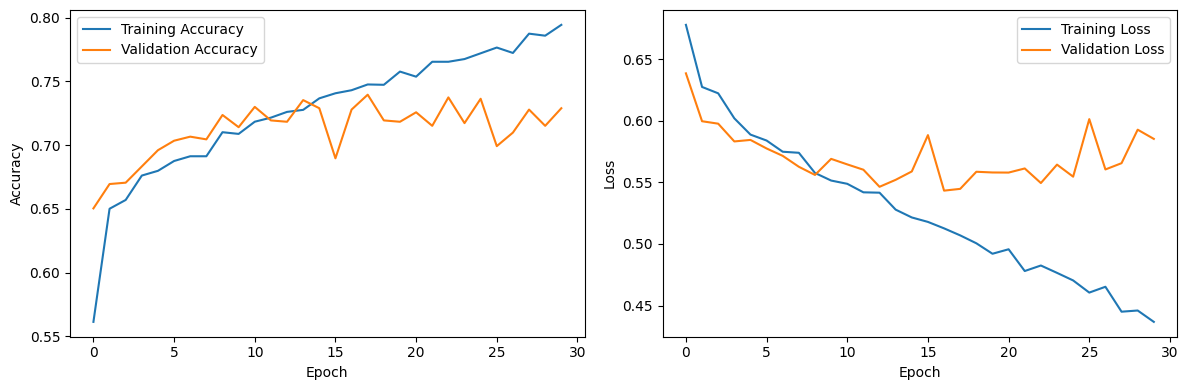

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Bi.history['accuracy'], label='Training Accuracy')
plt.plot(history_Bi.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Bi.history['loss'], label='Training Loss')
plt.plot(history_Bi.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

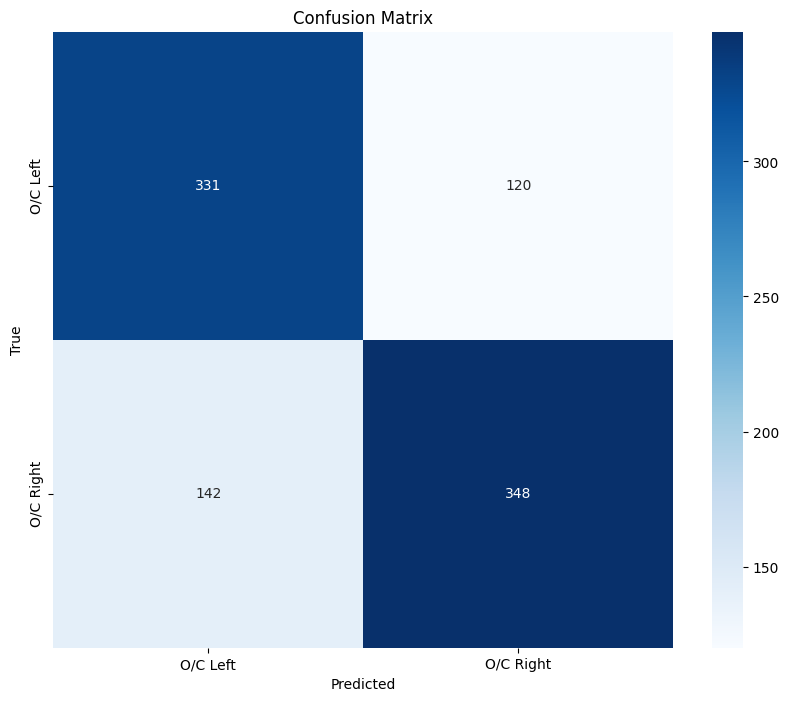

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam
# opt = Adam(learning_rate=0.002)

# Define the advanced 1D CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.33),
    Conv1D(16, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    MaxPooling1D(pool_size=2),
    Dropout(0.33),
    Flatten(),
    Dense(32, activation=tf.nn.leaky_relu),
    Dropout(0.33),
    Dense(32, activation=tf.nn.leaky_relu),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
opt = Adam(learning_rate=0.0004)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model.fit(x_train, y_train, epochs=40 , batch_size=64, validation_data=(x_test, y_test))

Epoch 1/40
59/59 [==============================] - 5s 41ms/step - loss: 0.7068 - accuracy: 0.5060 - val_loss: 0.6929 - val_accuracy: 0.5090
Epoch 2/40
59/59 [==============================] - 3s 46ms/step - loss: 0.6916 - accuracy: 0.5238 - val_loss: 0.6896 - val_accuracy: 0.5473
Epoch 3/40
59/59 [==============================] - 3s 43ms/step - loss: 0.6871 - accuracy: 0.5358 - val_loss: 0.6847 - val_accuracy: 0.5834
Epoch 4/40
59/59 [==============================] - 2s 37ms/step - loss: 0.6795 - accuracy: 0.5626 - val_loss: 0.6762 - val_accuracy: 0.6323
Epoch 5/40
59/59 [==============================] - 2s 34ms/step - loss: 0.6689 - accuracy: 0.5980 - val_loss: 0.6621 - val_accuracy: 0.6451
Epoch 6/40
59/59 [==============================] - 2s 33ms/step - loss: 0.6627 - accuracy: 0.6076 - val_loss: 0.6621 - val_accuracy: 0.6451
Epoch 7/40
59/59 [==============================] - 2s 35ms/step - loss: 0.6612 - accuracy: 0.6163 - val_loss: 0.6528 - val_accuracy: 0.6482
Epoch 8/40
59

30/30 [==============================] - 0s 4ms/step - loss: 0.5899 - accuracy: 0.7120
Test accuracy: 0.7120084762573242
Kappa: 0.42287315299085915
F1 Score: 0.7243133265513734
Precision: 0.7221095334685599
Recall: 0.726530612244898


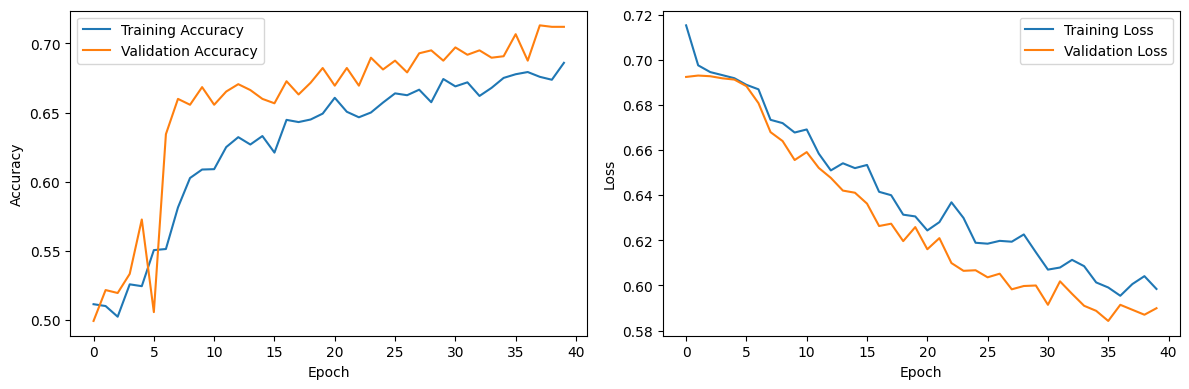

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

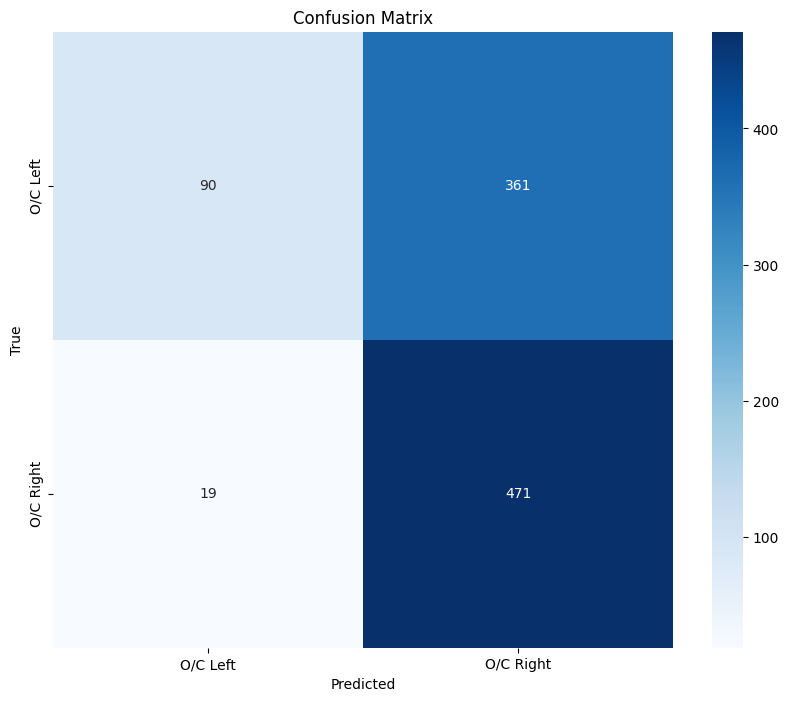

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Split the data randomly into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_t, labels, test_size=0.2, random_state=999)

In [ ]:
# Define the advanced 1D CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.45),
    Conv1D(32, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    MaxPooling1D(pool_size=2),
    # Flatten(),
    Bidirectional(LSTM(32, recurrent_dropout=0.2, return_sequences=True)),
    Dropout(0.4),
    Dense(10, activation=tf.nn.leaky_relu),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
    ])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))
# Train the model
epochs_no= 50

Epoch 1/40
118/118 [==============================] - 15s 70ms/step - loss: 0.6895 - accuracy: 0.5464 - val_loss: 0.6789 - val_accuracy: 0.5834
Epoch 2/40
118/118 [==============================] - 9s 76ms/step - loss: 0.6689 - accuracy: 0.6110 - val_loss: 0.6491 - val_accuracy: 0.6472
Epoch 3/40
118/118 [==============================] - 9s 74ms/step - loss: 0.6482 - accuracy: 0.6461 - val_loss: 0.6402 - val_accuracy: 0.6567
Epoch 4/40
118/118 [==============================] - 7s 63ms/step - loss: 0.6322 - accuracy: 0.6626 - val_loss: 0.6112 - val_accuracy: 0.6876
Epoch 5/40
118/118 [==============================] - 9s 79ms/step - loss: 0.6242 - accuracy: 0.6660 - val_loss: 0.6061 - val_accuracy: 0.7014
Epoch 6/40
118/118 [==============================] - 7s 62ms/step - loss: 0.6150 - accuracy: 0.6769 - val_loss: 0.6044 - val_accuracy: 0.6950
Epoch 7/40
118/118 [==============================] - 9s 78ms/step - loss: 0.6093 - accuracy: 0.6769 - val_loss: 0.6047 - val_accuracy: 0.678

30/30 [==============================] - 0s 12ms/step - loss: 0.5751 - accuracy: 0.6993
Test accuracy: 0.6992561221122742
Kappa: 0.3997547655057848
F1 Score: 0.6979722518676628
Precision: 0.7315436241610739
Recall: 0.6673469387755102


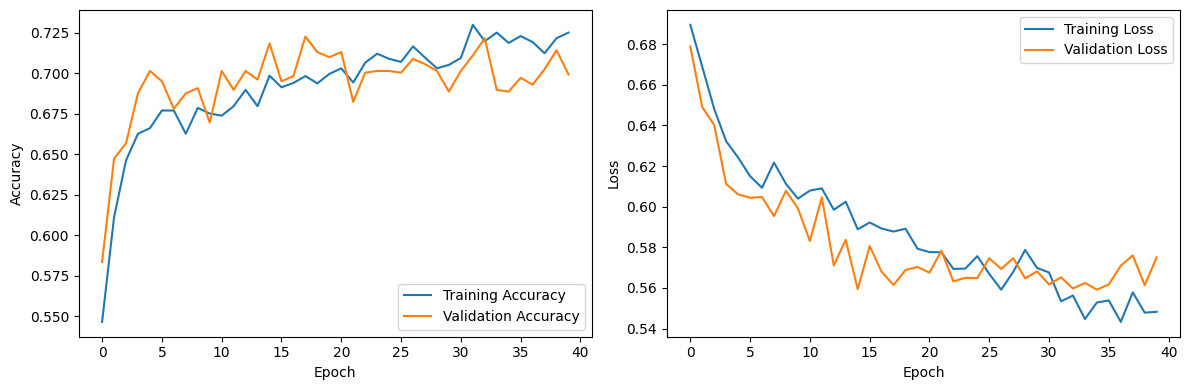

In [ ]:
  # Calculate additional metrics
  y_pred = model.predict(x_test)
  y_pred_classes = (y_pred > 0.5).astype(int)

  kappa = cohen_kappa_score(y_test, y_pred_classes)
  f1 = f1_score(y_test, y_pred_classes)
  precision = precision_score(y_test, y_pred_classes)
  recall = recall_score(y_test, y_pred_classes)
  # Evaluate the model
  test_loss, test_acc = model.evaluate(x_test, y_test)

  print("Test accuracy:", test_acc)
  print("Kappa:", kappa)
  print("F1 Score:", f1)
  print("Precision:", precision)
  print("Recall:", recall)

  # Plot accuracy and loss over epochs
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
  plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history_cnn.history['loss'], label='Training Loss')
  plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

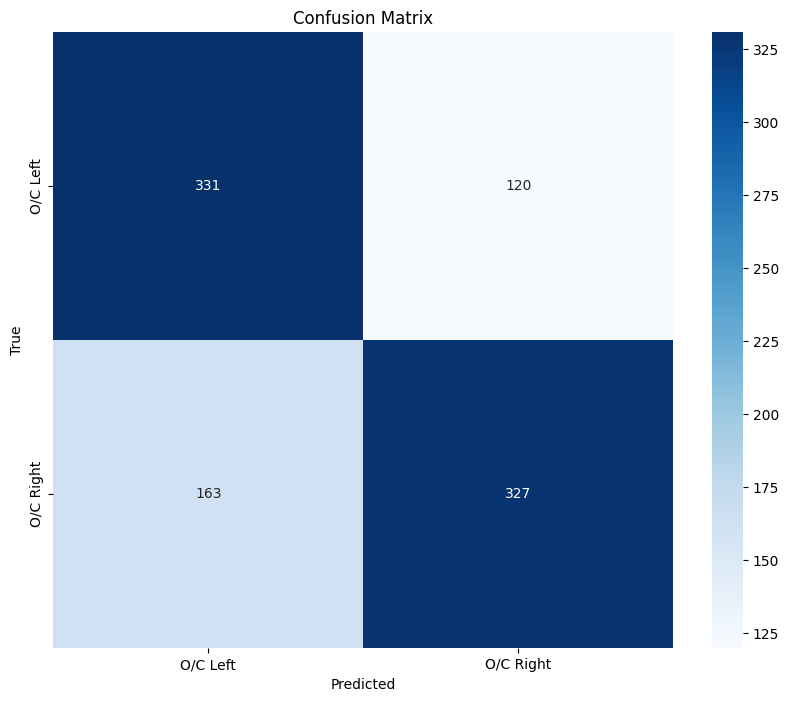

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from tensorflow.keras.layers import GRU
tf.random.set_seed(42)

# Define the advanced 1D CNN model with a GRU layer
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    GRU(32,recurrent_dropout=0.25, return_sequences=True),  # Adding a GRU layer with 64 units
    Dropout(0.3),
    GRU(16,recurrent_dropout=0.25, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = Adam(learning_rate=0.0008)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_gru = model.fit(x_train, y_train, epochs=55, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/55
118/118 [==============================] - 27s 81ms/step - loss: 0.6905 - accuracy: 0.5350 - val_loss: 0.6799 - val_accuracy: 0.6100
Epoch 2/55
118/118 [==============================] - 9s 77ms/step - loss: 0.6689 - accuracy: 0.5921 - val_loss: 0.6554 - val_accuracy: 0.6557
Epoch 3/55
118/118 [==============================] - 8s 64ms/step - loss: 0.6515 - accuracy: 0.6240 - val_loss: 0.6403 - val_accuracy: 0.6546
Epoch 4/55
118/118 [==============================] - 9s 72ms/step - loss: 0.6449 - accuracy: 0.6381 - val_loss: 0.6293 - val_accuracy: 0.6642
Epoch 5/55
118/118 [==============================] - 8s 71ms/step - loss: 0.6308 - accuracy: 0.6506 - val_loss: 0.6245 - val_accuracy: 0.6716
Epoch 6/55
118/118 [==============================] - 8s 65ms/step - loss: 0.6294 - accuracy: 0.6514 - val_loss: 0.6193 - val_accuracy: 0.6801
Epoch 7/55
118/118 [==============================] - 9s 75ms/step - loss: 0.6241 - accuracy: 0.6535 - val_loss: 0.6308 - val_accuracy: 0.673

30/30 [==============================] - 2s 51ms/step - loss: 0.5916 - accuracy: 0.7014
Test accuracy: 0.701381504535675
Kappa: 0.396140539182662
F1 Score: 0.7410138248847927
Precision: 0.6756302521008404
Recall: 0.8204081632653061


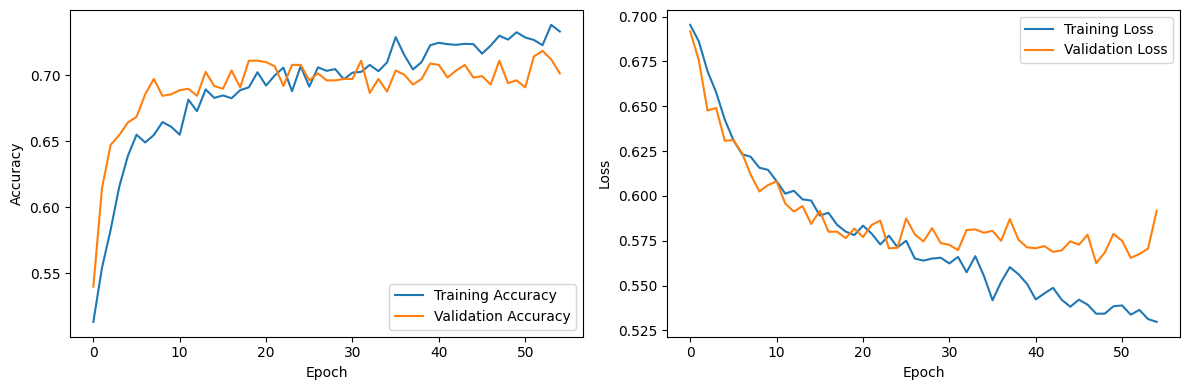

In [ ]:
 # Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_gru.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_gru.history['loss'], label='Training Loss')
plt.plot(history_cnn_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

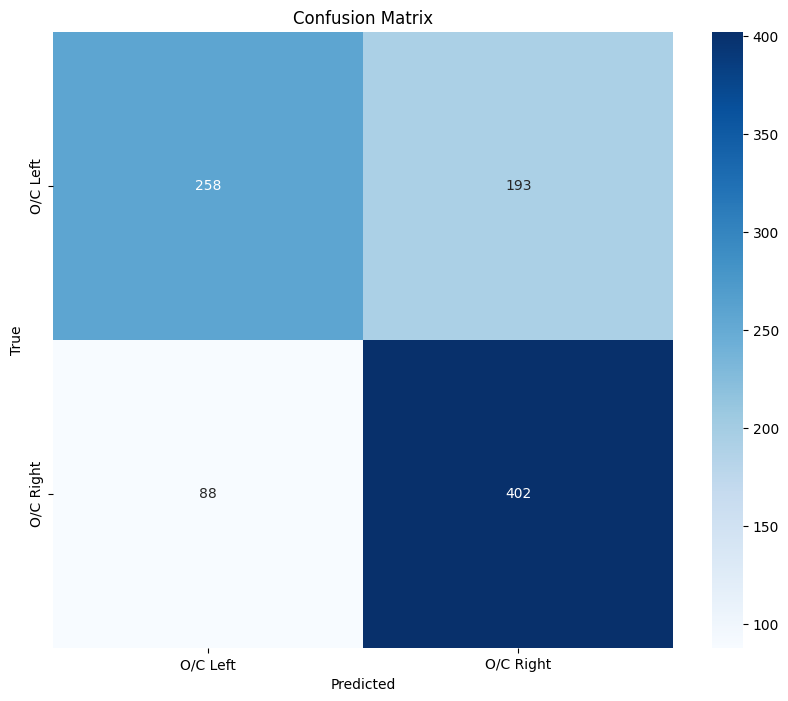

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()